<center><h1> Focal Loss </h1>
John Ignacio R.M. 17 JUN 2020</center>

In [2]:
import numpy as np
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.model import BinaryClassifier, Sequential, Dense, Dropout, adagrad
from ada2.data import read_dataset, split_dataset
import pandas as pd
from functools import partial

In [3]:
source_path = "../processed_data/xtohh"
signal = "Xtohh2000"
bg = "Xtohh_background"
seed = 420

In [4]:
#read xtohh dataset
df = read_dataset(source_path, signal, bg, "SR", 2)
sets = split_dataset(df, 0.6, 0.2, 0.2, seed)

In [5]:
from tensorflow import convert_to_tensor, constant, clip_by_value, math
from tensorflow.keras.backend import mean, epsilon
from tensorflow import nn

def get_binary_crossentropy(target, output):
    epsilon_ = constant(epsilon(), output.dtype.base_dtype)
    output = clip_by_value(output, epsilon_, 1. - epsilon_)

    bce = target * math.log(output + epsilon())
    bce += (1 - target) * math.log(1 - output + epsilon())
    return -bce

def keras_binary_crossentropy(y_true, y_pred):
    return mean(get_binary_crossentropy(y_true, y_pred), axis=-1)

def get_focal_loss(target, output, alpha, gamma):
    epsilon_ = constant(epsilon(), output.dtype.base_dtype)
    output = clip_by_value(output, epsilon_, 1. - epsilon_)

    bce = target * math.log(output + epsilon()) * (1 - output)**gamma
    bce += (1 - target) * math.log(1 - output + epsilon()) * (output)**gamma
    return -alpha * bce

def focal_loss(alpha, gamma):

    def focal_loss_aux(y_true, y_pred):
        return mean(get_focal_loss(y_true, y_pred, alpha, gamma), axis=-1)
        
    return focal_loss_aux

def sof_binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.

    # Arguments
        target: A tensor with the same shape as `output`.
        output: A tensor.
        from_logits: Whether `output` is expected to be a logits tensor.
            By default, we consider that `output`
            encodes a probability distribution.

    # Returns
        A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        _epsilon = convert_to_tensor(epsilon(), dtype = output.dtype.base_dtype)
        output = clip_by_value(output, _epsilon, 1 - _epsilon)
        output = math.log(output / (1 - output))

    bce = nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    return mean(bce, axis = -1)

In [21]:
class BinClassifModel4(BinaryClassifier):

    def __init__(self, n_input, loss):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(32, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
        #hidden layers
        self.model.add(Dropout(rate=0.2))
        #self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        #self.model.add(Dropout(rate=0.2))
        #self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        #self.model.add(Dropout(rate=0.2))
        #self.model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
        #self.model.add(Dropout(rate=0.2))
        #self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        #self.model.add(Dropout(rate=0.2))
        #self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        #self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(32, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adagrad(lr=0.05), loss=loss)

        #training
        self.history = None

        #name
        self.model_name = "BCM4"

In [22]:
#from keras.losses import BinaryCrossentropy
#bce = BinaryCrossentropy()

In [23]:
model = BinClassifModel4(sets["x"]["train"].shape[1], focal_loss(1,4))
model.fit(
    sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
    sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
    20
)

Train on 5283 samples, validate on 1761 samples
Epoch 1/20
5283/5283 [==============================] - 2s 310us/step - loss: 1.6232e-04 - val_loss: 9.9904e-06
Epoch 2/20
5283/5283 [==============================] - 1s 108us/step - loss: 3.4968e-05 - val_loss: 9.0042e-06
Epoch 3/20
5283/5283 [==============================] - 1s 107us/step - loss: 2.9902e-05 - val_loss: 9.2074e-06
Epoch 4/20
5283/5283 [==============================] - 1s 111us/step - loss: 2.8684e-05 - val_loss: 9.7105e-06
Epoch 5/20
5283/5283 [==============================] - 1s 110us/step - loss: 2.6863e-05 - val_loss: 8.6995e-06
Epoch 6/20
5283/5283 [==============================] - 1s 111us/step - loss: 2.3198e-05 - val_loss: 1.0858e-05
Epoch 7/20
5283/5283 [==============================] - 1s 107us/step - loss: 2.2794e-05 - val_loss: 6.0699e-06
Epoch 8/20
5283/5283 [==============================] - 1s 109us/step - loss: 2.2889e-05 - val_loss: 4.8293e-06
Epoch 9/20
5283/5283 [==============================] - 

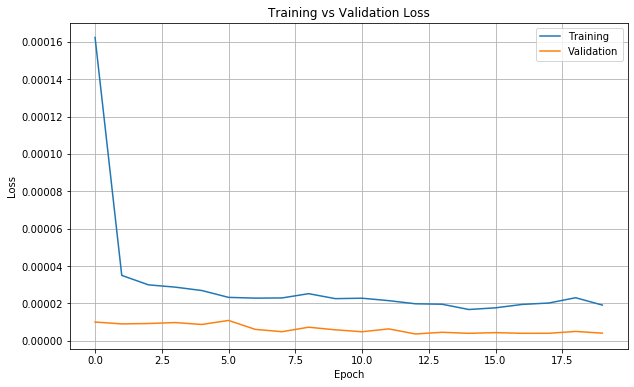

In [82]:
model.plot_loss()

In [83]:
x_train = sets["x"]["train"]
y_train = sets["y"]["train"]
w_train = sets["w"]["train"]
x_val = sets["x"]["val"]
y_val = sets["y"]["val"]
w_val = sets["w"]["val"]

In [84]:
x_test = sets["x"]["test"]
y_test = sets["y"]["test"]
w_test = sets["w"]["test"]

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [86]:
y_pred_train = model.predict(x_train,th=0.5)
acc= accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train)
rec = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
print(acc, prec, rec, f1)

0.9776642059435926 0.9907825063737988 0.9861409330470428 0.9884562707884953


In [87]:
y_pred_test = model.predict(x_test,th=0.5)
acc= accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(acc, prec, rec, f1)

0.9721906923950057 0.9894304169113329 0.9819347319347319 0.985668324071366


In [88]:
y_pred_val = model.predict(x_val,th=0.5)
acc= accuracy_score(y_val, y_pred_val)
prec = precision_score(y_val, y_pred_val)
rec = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
print(acc, prec, rec, f1)

0.9823963657013061 0.9929988331388565 0.9889599070307961 0.9909752547307134


In [89]:
for key in sets["y"].keys():
    print("-------", key)
    print(sets["y"][key].sum(),sets["y"][key].shape,sets["y"][key].shape[0]- sets["y"][key].sum())
    pred = model.predict(sets["x"][key],th=0.5)
    cm1= confusion_matrix(sets["y"][key], pred)
    acc = accuracy_score(sets["y"][key], pred)
    prec = precision_score(sets["y"][key], pred)
    rec = recall_score(sets["y"][key], pred)
    print(cm1)
    print(acc, prec, rec)

------- train
5123 (5283, 1) 160
[[ 113   47]
 [  71 5052]]
0.9776642059435926 0.9907825063737988 0.9861409330470428
------- val
1721 (1761, 1) 40
[[  28   12]
 [  19 1702]]
0.9823963657013061 0.9929988331388565 0.9889599070307961
------- test
1716 (1762, 1) 46
[[  28   18]
 [  31 1685]]
0.9721906923950057 0.9894304169113329 0.9819347319347319


In [41]:
weighted_class_report = classification_report(y_test, y_pred_test, output_dict = True, sample_weight=w_test)

In [43]:
weighted_class_report.keys()

dict_keys(['0', '1', 'micro avg', 'macro avg', 'weighted avg'])

In [45]:
weighted_class_report["0"]

{'precision': 0.9120971670981547,
 'recall': 0.6730520500027134,
 'f1-score': 0.7745502587319093,
 'support': 0.46800015233700004}

In [46]:
weighted_class_report["1"]

{'precision': 0.925760196316418,
 'recall': 0.9843391664378495,
 'f1-score': 0.9541514307920073,
 'support': 1.9383916775903427}

In [47]:
x_train

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,0.128458,0.444064,-0.745452,-1.657235,-0.481872,-0.820906,0.988531,-0.702398,0.286334,-0.060290,-0.308709,1.126562,-0.536886,0.342590
1,-0.156988,-0.757389,-1.496936,-0.586347,0.566530,-0.956854,0.265225,-0.189615,0.638970,-0.390017,-0.565041,-0.443050,-0.440012,-0.841343
2,0.909215,-0.559890,-1.669714,1.426536,0.032083,0.765652,0.099236,-0.281315,0.723581,0.298984,0.002194,0.823494,0.618808,0.595511
3,0.196879,-0.114628,1.323253,0.476223,0.194285,-1.168272,-0.466495,-0.278684,-0.281268,-0.609143,0.190864,1.194448,-0.081120,-0.049415
4,0.394505,-0.213164,-1.239563,-0.037726,-0.663591,0.236512,0.670940,-0.901349,-0.626829,-1.113055,0.052019,1.894388,-1.087163,0.857332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5278,1.006997,-1.203808,1.145668,0.292682,1.516370,-1.396302,-0.715172,0.880720,-1.085958,-1.488413,0.651004,0.021390,0.914520,0.139117
5279,0.251795,-0.715543,-1.414500,0.168332,-1.586405,0.636028,0.311082,-0.947185,0.217812,0.029894,-0.824856,1.393681,-1.495175,1.399821
5280,1.117179,-0.891977,1.405008,0.628997,0.026455,-0.173522,-0.308908,-0.711637,0.581483,-0.208427,-0.379907,1.154322,0.143942,0.796931
5281,2.511596,-0.225271,-0.347615,2.846056,1.790106,0.558085,1.449185,0.087994,0.708370,-0.123917,0.312319,0.917576,2.557956,0.556232


In [48]:
import seaborn as sns

In [49]:
bool_train_labels = y_train != 0



In [51]:
x_train.columns

Index(['m_FJpt', 'm_FJeta', 'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi',
       'm_DTm', 'm_dPhiFTwDT', 'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm',
       'm_bbttpt'],
      dtype='object')

In [53]:


pos_df = pd.DataFrame(x_train[ bool_train_labels], columns = x_train.columns)
neg_df = pd.DataFrame(x_train[~bool_train_labels], columns = x_train.columns)




In [80]:
pos_df['m_DTpt'].min()

-1.6461303376627774

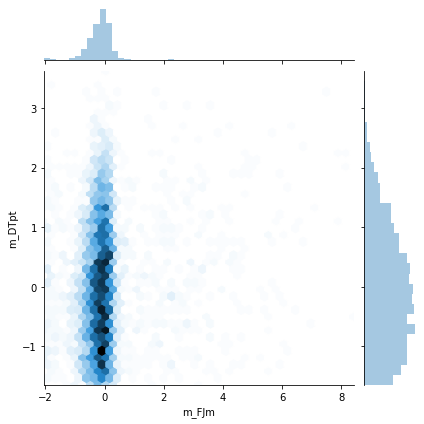

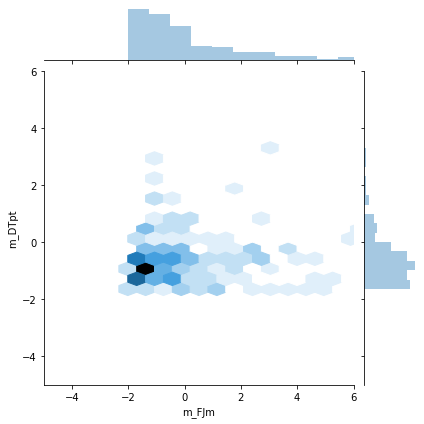

In [81]:
sns.jointplot(pos_df['m_FJm'], pos_df['m_DTpt'], kind='hex', xlim = (pos_df['m_FJm'].min(),pos_df['m_FJm'].max()),
              ylim = (pos_df['m_DTpt'].min(),pos_df['m_DTpt'].max()))
#plt.title("Positive distribution")


sns.jointplot(neg_df['m_FJm'], neg_df['m_DTpt'],
             kind='hex', xlim = (-5,6), ylim = (-5,6))
#_ = plt.suptitle("Negative distribution")